## Import libraries and read in data

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import List
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
#import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import PIL
from PIL import Image, ImageDraw
import torchvision.models as models

#from pytorch_lightning.callbacks import EarlyStopping
#from pytorch_lightning.loggers import WandbLogger  


import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip -qo 'drive/MyDrive/Copy of archive' -d '/content/data'

In [ ]:
path = "/content/data/UTKFace/"
files = os.listdir(path)
print("Total samples:", len(files))
print(files[0])

Total samples: 23708
26_1_3_20170104232120449.jpg.chip.jpg


We can extract the needed labels (age and gender) from the file names. The first number in the file name is age, the second number is gender (0 for male, 1 for female).

In [ ]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(124,124))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

Now let's put everything into a dataframe and check for missing values.

In [ ]:
data = {'img_file': files, 'gender': genders, 'age': ages}
df = pd.DataFrame(data=data)
df['age'] = df['age'].astype(int)
df.head()

,img_file,gender,age
0,26_1_3_20170104232120449.jpg.chip.jpg,1,26
1,23_1_1_20170114033629976.jpg.chip.jpg,1,23
2,60_0_0_20170111201620287.jpg.chip.jpg,0,60
3,55_0_3_20170119202724469.jpg.chip.jpg,0,55
4,1_1_3_20161220143357382.jpg.chip.jpg,1,1


In [ ]:
df.isnull().sum()

img_file    0
gender      0
age         0
dtype: int64

## EDA & Preprocessing

Let's start with some simpe EDA and preprocessing: look at some of the images, split age into age groups and look at the age and gender distribution.

First, let's create a dictionary for genders where 0 is male, and 1 is female and print some examples.

In [ ]:
gender_map = {
    0: "Male",
    1: "Female"
}

In [ ]:
def show_images(df: pd.DataFrame) -> None:
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            image = cv2.imread(path+df.img_file[k],0)
            image = cv2.resize(image,dsize=(64,64))
            #image = image.reshape((image.shape[0],image.shape[1],1))
            
            ax[i,j].imshow(image , cmap='gray')
            ax[i,j].set_title(f'{gender_map[df.gender[k]]}, {df.age[k]}')
            k = k+1;
            
    plt.tight_layout()

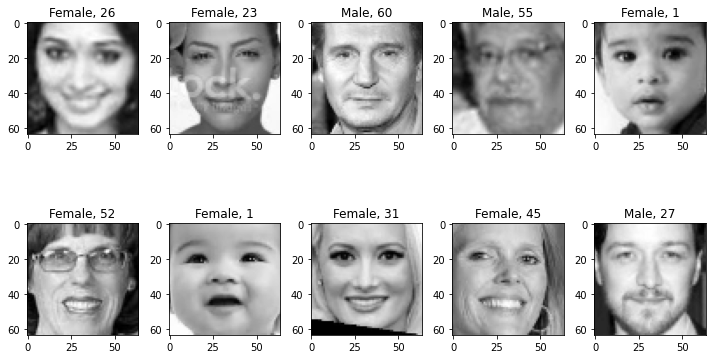

In [ ]:
show_images(df)

From the first look, the training data seems to be quite diverse, as it includes people of different races, genders and ages. Let's see how many samples there are for both genders.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


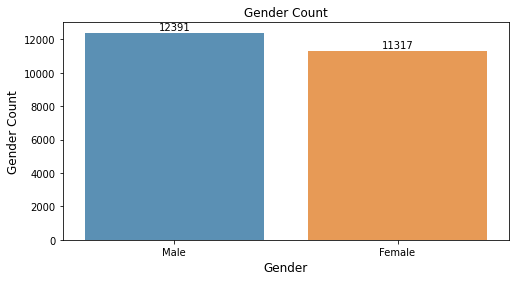

In [ ]:
plt.figure(figsize=(8,4))
ax = sns.countplot(df.gender, alpha=0.8)
plt.title("Gender Count")
plt.ylabel('Gender Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)

positions = (0, 1)
labels = ("Male", "Female")
plt.xticks(positions, labels)

#adding the text labels
labels = df.gender.value_counts().sort_index()
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

As we can see, the difference between female and male samples is not that big. Let's see how the age distribution looks. First, we need to find the range of ages and split the ages into age bins.

In [ ]:
print("Max age: ", df['age'].max())
print("Min age: ", df['age'].min())

Max age:  116
Min age:  1


In [ ]:
df['bin'] = pd.cut(df['age'], bins = [0,10,20,30,40,50,60,70,80,90,100,110,120],
                   labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110'])
df.head()

,img_file,gender,age,bin
0,26_1_3_20170104232120449.jpg.chip.jpg,1,26,20
1,23_1_1_20170114033629976.jpg.chip.jpg,1,23,20
2,60_0_0_20170111201620287.jpg.chip.jpg,0,60,50
3,55_0_3_20170119202724469.jpg.chip.jpg,0,55,50
4,1_1_3_20161220143357382.jpg.chip.jpg,1,1,0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


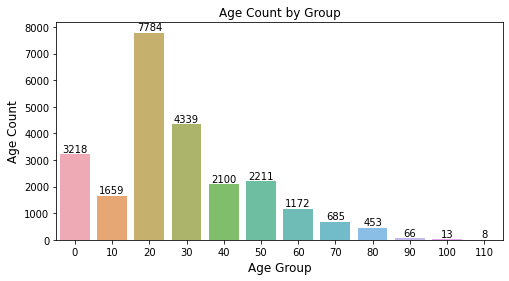

In [ ]:
plt.figure(figsize=(8,4))
ax = sns.countplot(df.bin, alpha=0.8)
plt.title("Age Count by Group")
plt.ylabel('Age Count', fontsize=12)
plt.xlabel('Age Group', fontsize=12)

#adding the text labels
rects = ax.patches
labels = df.bin.value_counts().sort_index()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

As we can see, the age classes are more imbalanced. The majority of people are between 20 and 40 years old. There are only 540 people that are older than 80. Let's see if how the age distribution looks for each gender.

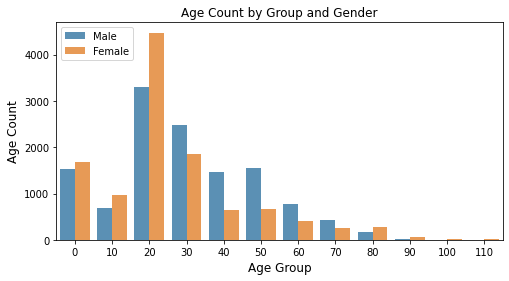

In [ ]:
plt.figure(figsize=(8,4))
ax = sns.countplot(df.bin, alpha=0.8, hue=df.gender)
plt.title("Age Count by Group and Gender")
plt.ylabel('Age Count', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.legend(labels=["Male","Female"])
plt.show()

As we can see, the majority of people in their 0s,10s and 20s are women and the majority of people older than 30 are men. Let's split the data into train and validation sets

In [ ]:
train, test = train_test_split(files, test_size=0.2, random_state=14,shuffle=True)
#train, val = train_test_split(files, test_size=0.2, random_state=14)
print("Samples in training set:",len(train))
#print("Samples in validation set:",len(val))
print("Samples in testing set:",len(test))

Samples in training set: 18966
Samples in testing set: 4742


## Modeling

Now let's define the image transformations (image resize, center crop, normalize, convert to tensor).

In [ ]:
preprocess = transforms.Compose([
   transforms.Resize(200),
   transforms.ToTensor(),
   transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

Now let's create a custom dataset that applies the transformations to the images and deals with the labels.

In [ ]:
path = "/content/data/UTKFace/"
files = os.listdir(path)
print("Total samples:", len(files))
print(files[3])
split_varr=files[3].split('_')

Total samples: 23708
55_0_3_20170119202724469.jpg.chip.jpg


In [ ]:
split_varr

['55', '0', '3', '20170119202724469.jpg.chip.jpg']

In [ ]:

class MultiTaskDataset(Dataset):
    def __init__(self, path: str, files: list, tfms):
    #def __init__(self, path: str, files: list):
        self.files = files
        self.path = path
        self.tfms = tfms


    def __len__(self): 
        return len(self.files)
    
    def __getitem__(self, idx: int):
        img_file = self.files[idx]
        img = PIL.Image.open(self.path + img_file).convert('RGB')
        img = self.tfms(img)
        
        split_var = self.files[idx].split('_')
        age = int(split_var[0])
        #age = torch.tensor(age, dtype=torch.float32)
        # age = torch.tensor(age, dtype=torch.int64)
        age = torch.tensor(age-1,dtype=torch.int64)
        #gender = torch.tensor(int(split_var[1]), dtype=torch.int64)
        gender = torch.tensor(int(split_var[1]))
        #gender=torch.tensor(gender,dtype=torch.int64)

        #return img, age.log_()/4.75, gender, img_file
        return img, age, gender, img_file


In [ ]:
config = {
    'batch_size': 256, # Increase this if your GPU can handle it.  // i think 512 is best for now, originally 64
    'lr': 0.001,
    'epochs': 150, 
}

In [ ]:
train_ds = MultiTaskDataset(path, train, preprocess)
#valid_ds = MultiTaskDataset(path, val, preprocess)
test_ds = MultiTaskDataset(path, test, preprocess)
# train_ds = MultiTaskDataset(path, train)
# valid_ds = MultiTaskDataset(path, val)
# test_ds = MultiTaskDataset(path, test)

In [ ]:
train_ds[10][1]

tensor(34)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = config['batch_size'], 
                                           shuffle = True,num_workers = 2)
#val_loader = torch.utils.data.DataLoader(valid_ds, batch_size = config['batch_size'], 
#                                         shuffle = False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = config['batch_size'], 
                                          shuffle = True,num_workers = 2)

In [ ]:
#print("Number of classes: ", len(train_dataset.classes))
print("No. of train images: ", train_ds.__len__())
print("Shape of image: ", train_ds[100][0].shape)
print("Batch size: ", config['batch_size'])
print("Train batches: ", train_loader.__len__())
print("Val batches: ", test_loader.__len__())

No. of train images:  18966
Shape of image:  torch.Size([3, 200, 200])
Batch size:  256
Train batches:  75
Val batches:  19


Now we can begin the modeling part. We are going to apply [transfer learning](https://pytorch-lightning.readthedocs.io/en/stable/advanced/transfer_learning.html) using ResNet34. We’ll pack everything in [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html). This is a multi-task learning task, because we have to predict the age and gender based on the input image. Predicting age is a regression problem with a single output, predicting gender is a classification problem with two outputs. With that in mind, we can create the model.

In [ ]:
# resnet34
# resnet block
class ResBlock(nn.Module):
    def __init__(self, in_channel,out_channel, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.stride = stride
        self.relu2 = nn.ReLU()
        self.downsample = downsample


    def forward(self, x):
        shortcut = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
          shortcut = self.downsample(x)
        
        out += shortcut
        out = self.relu2(out)

        return out

In [ ]:
# resnet34
# resnet block
class BasicBlock(nn.Module):
    def __init__(self, in_channel,out_channel, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.stride = stride
        self.relu2 = nn.ReLU()
        self.downsample = downsample


    def forward(self, x):
        shortcut = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
          shortcut = self.downsample(x)
        
        out += shortcut
        out = self.relu2(out)

        return out

In [ ]:
from torch.nn.modules.activation import ReLU
class Network_AGE(nn.Module):
    def __init__(self, block, num_classes=116):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.in_channel = 64
        self.layer1 = nn.Sequential(
            block(64, 64),
            block(64, 64),
            block(64, 64)
        )       
        self.layer2 = self._make_layer(block, 128, 4, stride=2)
        self.layer3 = self._make_layer(block, 256, 6, stride=2)
        self.layer4 = self._make_layer(block, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.cls_layer = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, outchannel, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != outchannel:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, outchannel, 1, stride, bias=False),
                nn.BatchNorm2d(outchannel),
            )
        layers = []
        layers.append(block(self.in_channel, outchannel, stride, downsample))
        self.in_channel = outchannel

        for i in range(1, blocks):
            layers.append(block(self.in_channel, outchannel))
        return nn.Sequential(*layers)

    
    def forward(self, x, return_feats=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)     # convert 1 X 1 to vector
        x = self.cls_layer(x)

        return x



In [ ]:
from torch.nn.modules.activation import ReLU
class Network_GENDER(nn.Module):
    def __init__(self, block, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) # TODO: Conv group 1
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.in_channel = 64
        self.layer1 = nn.Sequential(
            block(64, 64),
            block(64, 64),
            block(64, 64)
        )       
        self.layer2 = self._make_layer(block, 128, 4, stride=2)
        self.layer3 = self._make_layer(block, 256, 6, stride=2)
        #self.linear = nn.Linear(512, 512)
        #self.dropout = nn.Dropout(0.2)
        self.layer4 = self._make_layer(block, 512, 3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.cls_layer = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, outchannel, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != outchannel:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, outchannel, 1, stride, bias=False),
                nn.BatchNorm2d(outchannel),
            )
        layers = []
        layers.append(block(self.in_channel, outchannel, stride, downsample))
        self.in_channel = outchannel

        for i in range(1, blocks):
            layers.append(block(self.in_channel, outchannel))
        return nn.Sequential(*layers)

    
    def forward(self, x, return_feats=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.linear(x)
        #x = self.dropout(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)     # convert 1 X 1 to vector
        x = self.cls_layer(x)

        return x



In [ ]:
model_age=Network_AGE(ResBlock)
model_age.cuda()
model_gender=Network_GENDER(ResBlock)
model_gender.cuda()

Network_GENDER(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (con

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
# model template
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.pooling import AdaptiveAvgPool2d
from torch.nn.modules.activation import ReLU
# class Network(torch.nn.Module):

#     def __init__(self, num_classes=116):
#         super().__init__()

    
#     def forward(self, x, return_feats=False):

            
# model = Network().to(device)


In [ ]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [ ]:
model=ResNet50(num_classes=116).to(device)

In [ ]:
#criterion_age = torch.nn.CrossEntropyLoss(label_smoothing=0.5)
criterion_age = torch.nn.CrossEntropyLoss()
criterion_gender=torch.nn.MSELoss()
#criterion=torch.nn.TripletMarginLoss()

# TODO: What loss do you need for a multi class classification problem?

optimizer_age = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
#optimizer_age = torch.optim.SGD(model_age.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
##optimizer_gender = torch.optim.SGD(model_gender.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)

#scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.6,patience=2,threshold=0.01,cooldown=0,eps=0.000000001)
scheduler_age=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_age, mode='max', factor=0.2, patience=3, threshold=0.0001)
#scheduler_gender=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_age, mode='max', factor=0.2, patience=3, threshold=0.0001)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

In [ ]:
import torch
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
#import wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

#import torchvision.transforms as ttf

Device:  cuda


In [ ]:
def train_age(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 
    
    num_correct = 0
    total_loss = 0.

    for i, (images, labels,another_label,fileName) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

       # images, labels = images.to(device).type(torch.Tensor), labels.to(device).type(torch.Tensor)
        #labels =labels.type(torch.LongTensor)   # casting to long
        images, labels = images.to(device), labels.to(device)

        #targets.type(torch.LongTensor)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        # num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())


        total_loss += float(loss.item())
        #total_loss += loss.item()

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() 
        # loss.backward()
        # optimizer.step()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def train_gender(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 
    
    num_correct = 0
    total_loss = 0

    for i, (images, another_label,labels,fileName) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        #labels =labels.type(torch.LongTensor)   # casting to long
        images, labels = images.to(device), labels.to(device)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        
        # scaler.scale(loss).backward() # This is a replacement for loss.backward()
        # scaler.step(optimizer) # This is a replacement for optimizer.step()
        # scaler.update() 
        loss.backward()
        optimizer.step()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
rangerange=0
# age difference : 0, 5, 15

In [ ]:

def validate_age(model, dataloader, criterion):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct_1=0.0
    num_correct_2=0.0
    num_correct_3=0.0

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels,another_label,fileName) in enumerate(dataloader):
        #labels =labels.type(torch.LongTensor)   # casting to long
        # Move images to device
        images, labels = images.to(device), labels.to(device)
        
        # Get model outputs
        with torch.inference_mode():
        #with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)

        #num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())

        bool_1=(torch.argmax(outputs, axis=1) >= labels-rangerange)
        bool_2=(torch.argmax(outputs, axis=1) <= labels+rangerange)
        bool_3=bool_1+bool_2

        #num_correct += int(((bool_1 and bool_2)==True).sum())
        #num_correct += int(((bool_1+bool_2) == True).sum())
        #num_correct += int((bool_3==True).sum())
        
        num_correct_1+= int((bool_1==True).sum())
        num_correct_2+= int((bool_2==True).sum())
        num_correct_3+= int((bool_3==True).sum())
        
        num_correct   = (num_correct_1+num_correct_2-num_correct_3)
        #num_correct  += int((bool_3==True).sum())



        #num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        # if (torch.argmax(outputs,axis=1)>=labels-5 and torch.argmax(outputs,axis=1)<=labels+5):
        #   num_correct=num_correct+1
        #print(labels)
        # print(bool_1+bool_2)

        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:

def validate_gender(model, dataloader, criterion):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, another_label,labels,fileName) in enumerate(dataloader):
        #labels =labels.type(torch.LongTensor)   # casting to long
        # Move images to device
        images, labels = images.to(device), labels.to(device)
        
        # Get model outputs
        with torch.inference_mode():
        #with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)


        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
import gc 
gc.collect()

21367

In [ ]:
#best_valacc = 0.00

for epoch in range(config['epochs']):
# for epoch in range(100):

    curr_lr_age = float(optimizer_age.param_groups[0]['lr'])
    #curr_lr_gender = float(optimizer_gender.param_groups[0]['lr'])

    train_acc_age, train_loss_age = train_age(model, train_loader, optimizer_age, criterion_age)
   #train_acc_age, train_loss_age = train_age(model_age, train_loader, optimizer_age, criterion_age)
    #train_acc_gender, train_loss_gender = train_gender(model_gender, train_loader, optimizer_gender, criterion_gender)



    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss age {:.04f}\t Learning Rate age {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc_age,
        train_loss_age,
        curr_lr_age))
    
    # print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss gender {:.04f}\t Learning Rate gender {:.04f}".format(
    #     epoch + 1,
    #     config['epochs'],
    #     train_acc_gender,
    #     train_loss_gender,
    #     curr_lr_gender))
    
    val_acc_age, val_loss_age = validate_age(model, test_loader, criterion_age)
    #val_acc_age, val_loss_age = validate_age(model_age, test_loader, criterion_age)
    # val_acc_age, val_loss_age = validate_age(model_age, val_loader, criterion_age)
    #val_acc_gender, val_loss_gender = validate_gender(model_gender, val_loader, criterion_gender)
    
    
    scheduler_age.step(train_acc_age)
    
    #scheduler_age.step(val_acc_age)
    #scheduler_gender.step(val_acc_gender)
    
    #scheduler.step()

    print("Val Acc age {:.04f}%\t Val Loss age {:.04f}".format(val_acc_age, val_loss_age))


Train:   0%|          | 0/75 [00:00<?, ?it/s]

OutOfMemoryError: ignored